In [6]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
import random

K-means Clustering

In [208]:
import random
import numpy as np

class KMeans():
    """K-means clustering
    """

    def __init__(self, k=2, max_iterations=100):
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = []

    def fit(self, X):
        """Compute cluster centroids for given data
        """
        # Initialise cluster centroids to random k data points
        self.centroids = self._init_random_centroids(X)

        # Run for max_iterations
        for _ in range(self.max_iterations):
            # Assign each data point to a cluster based on closest centroid
            cluster_labels = self._assign_clusters(X, self.centroids)
            prev_centroids = self.centroids
            # Calculate new cluster centroids
            self.centroids = self._calculate_centroids(X, cluster_labels)
            # Stopping critera: If centroids haven't changed
            diff = self.centroids - prev_centroids
            if not diff.any():
                break
        

    def predict(self, X):
        """Assign cluster labels to given data
        """
        return self._assign_clusters(X, self.centroids)
    

    def _init_random_centroids(self, X):
        """Initialise cluster centroids to random k data points"""
        num_samples, num_features = X.shape
        self.centroids = np.zeros((self.k, num_features))
        self.centroids = X[random.sample(range(0, num_samples-1), self.k)]
        return self.centroids

    def _assign_clusters(self, X, centroids):
        """Assign each data point to a cluster based on closest centroid"""
        cluster_labels = np.zeros((X.shape[0], 1)).astype(int)
        for sample_i, sample in enumerate(X):
            euclidean_distance = np.sqrt(np.sum((X[sample_i] - centroids)**2, axis=1))
            cluster_labels[sample_i] = np.argmin(euclidean_distance)
        return cluster_labels

    def _calculate_centroids(self, X, cluster_labels):
        centroids = np.zeros((self.k, X.shape[1]))
        # Calculate new cluster centroids
        for i in range(self.k):
            # Get indices of data points belonging to ith cluster
            # cluster_i_idx = np.array(random.sample(range(0, X.shape[0]-1), int(X.shape[0]/self.k)))
            cluster_i_idx = np.array(cluster_labels==i)
            cluster_i_idx = cluster_i_idx[:,0]
            # Compute mean of such data points
            centroids[i] = X[cluster_i_idx, :].mean(axis=0)
        return centroids

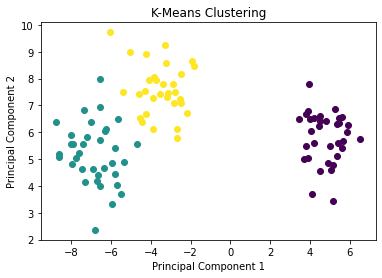

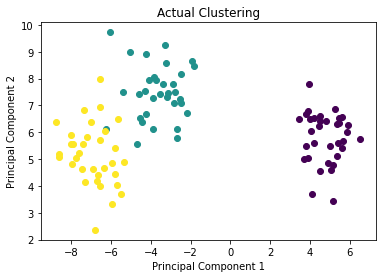

In [209]:
# Load the dataset
X, y = datasets.make_blobs()

# Cluster the data using K-Means
clf = KMeans(k=3)
clf.fit(X)
y_pred = clf.predict(X)
y_pred = y_pred[:,0]

# Project the data onto the 2 primary principal components
p = Plot()
p.plot_in_2d(X, y_pred, title="K-Means Clustering")
p.plot_in_2d(X, y, title="Actual Clustering")

In [3]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()